#Homework 1
<style>
table.series {
font-size:50%;
}
</style>

##PCA:

In [113]:
%reset -f

#Globals
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
import collections
import sys
import functools
from sklearn.metrics import confusion_matrix
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#Change this to location of data-bases
wineDataPath = "data/wine.data"
wineHeaders = ['Lab','Alc','Ma','Ash','Alk','Mag','Phe','Fla','NoFla','Pro','Col','Hue','OD','Pr']

TEST_MODE = 1
PCAResult = collections.namedtuple('PCAResult', ['eigenValues', 'eigenVectors', 'mean', 'deviation'])
LDAResult = collections.namedtuple('LDAResult', ['eigenValues', 'eigenVectors', 'means', 'covariance'])
identificationStrings = ["5 samples", "50 samples", "10-fold cross validation"]

In [114]:
#Visualization routines
def visualizeCumulativeSum(values):
    sumValues = np.linalg.norm(values, 1)
    plt.plot(np.arange(0,values.shape[0]), values/sumValues, color='y')
    plt.plot(np.arange(0,values.shape[0]), values/sumValues, 'o', color='r')
    
def visualizeEigenVector(vectors, index):
    print(vectors[:, index])

def visualizeEigenImage(vectors, index, plotNum=(1,1,1), title=""):
    image = vectors[:,index]
    plt.subplot(plotNum[0], plotNum[1], plotNum[2])
    plt.imshow(image.reshape(28,28).T, origin='upper', cmap = cm.Greys_r)
    plt.title(title)
    
#Given an object with eigenVectors, visualize the eigenVectors at the passed in indices
def visualizeEigenvectors(result, eigenVectorIndices):
    visualizeCumulativeSum( result.eigenValues )
    for eigenVectorIndex in eigenVectorIndices:
        print("%dth eigenvector: " %(eigenVectorIndex+1))
        visualizeEigenVector( result.eigenVectors, eigenVectorIndex )
    plt.show()

def visualizeEigenImages(result, eigenVectorIndices):
    subplotColumn = 1
    plt.subplot(1, 1+len(eigenVectorIndices), subplotColumn)
    visualizeCumulativeSum( result.eigenValues )
    for eigenVectorIndex in eigenVectorIndices:
        subplotColumn = subplotColumn + 1
        subPlot = (1, 1+len(eigenVectorIndices), subplotColumn)
        visualizeEigenImage( result.eigenVectors, eigenVectorIndex , subPlot, "%dth eigenvector: " %(eigenVectorIndex+1))
    plt.show()
    
def displayConfusionMatrix(classificationResult, groundTruth):
    classes = np.unique(groundTruth)
    for classLabelRow in classes:
        print (classLabelRow, "  ||  ", end=""),
        for classLabelColumn in classes:
            print (np.sum((groundTruth == classLabelRow) & (classificationResult == classLabelColumn)), "|", end="")
        print("\n")    

def plotConfusionMatrix(classificationResult, groundTruth):
    classes = np.unique(groundTruth)
    cm = confusion_matrix(groundTruth, classificationResult, classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def displayAccuracy(classificationResult, groundTruth):
    print ("Accuracy = %f%%" %(100*np.sum(groundTruth == classificationResult)/len(groundTruth)))

In [115]:
#Matrix manipulation routines / projections, unprojections, etc
#Given an object with eigenValues and a threshhold, returns number of eigenVectors to use as basis
def getNumEigenVectorsToUse(result, threshHold):
    sumValues = result.eigenValues.sum()
    scaledValues = result.eigenValues/sumValues
    for j in range(0,result.eigenValues.shape[0]):
        if scaledValues[j] < threshHold:
            break
    return j+1

#Given an object with sorted eigenVectors, returns first numBasis as basis (column-basis)
def getEigenBasis(result, numBasis):
    return result.eigenVectors[:,:numBasis]

#Project row-data matrix to a column-basis
def getProjection(data, result, numBasis):
    basis = getEigenBasis(result, numBasis)
    projection = (basis.T.dot(data.T)).T
    return projection

#Reconstruct as expressed in another column-basis
def getReconstruction(projection, result, numBasis):
    basis = getEigenBasis(result, numBasis)
    reconstruction = (basis.dot(projection.T)).T
    return reconstruction

def computeLossyReconstruction(testSample, result, threshHold):
    numBasis = getNumEigenVectorsToUse(result, threshHold)
    print("Number of eigenvectors being used ", numBasis)
    basis = getEigenBasis(result, numBasis)
    projection = getProjection(testSample, result, numBasis)
    reconstruction = getReconstruction(projection, result, numBasis)
    return reconstruction

def testReconstruction(testSample, result, threshHold):
    numBasis = getNumEigenVectorsToUse(result, threshHold)       
    basis = getEigenBasis(result, numBasis)
    if TEST_MODE:
       #Use all eigenVectors and see that reconstruction error is zero
       numBasis = eigenValues[i].shape[0] 
       print("Number of eigenvectors being used ", numBasis)
    projection = getProjection(testSample, result, numBasis)
    reconstruction = getReconstruction(projection, result, numBasis)
    if TEST_MODE:
        assert(np.allclose(np.linalg.norm(basis[:,0]), 1)) #Unit basis
        assert(np.allclose(basis[:,1].dot(basis[:,5].T), 0)) #Orthogonal basis
        assert(np.allclose(reconstruction - testSample, 0)) #Complete reconstruction
        return reconstruction
    
#Normalize and center-mean the sample wrt already calculated mean and deviation. Data is in rows.
def standardize(data, mean, deviation):
    centeredSample = testingSample - mean
    standardizedData = centeredSample / deviation
    return standardizedData

In [116]:
#Data handling routings
def readData(dataPath, columnHeaders):
    loadedData = pandas.read_csv(dataPath, names=columnHeaders)
    return loadedData  

def getTrainingData(iteration, data, classColumnName, classLabels):   
    trainingData = pandas.DataFrame()
    if iteration != 2:
        numSamples = 5 if iteration == 0 else 50
        for classLabel in classLabels:
            trainingData = trainingData.append(data[data[classColumnName] == classLabel].sample(numSamples))
    else:
        for classLabel in classLabels:
            trainingData = trainingData.append(data[data[classColumnName] == classLabel].sample(numSamples))
    trainingLabels = trainingData[classColumnName]
    trainingDataUnlabeled = trainingData.drop(classColumnName, axis=1)   
    return {'labels':trainingLabels, 'data':trainingDataUnlabeled}

In [117]:
#Functions for the wine data-base
def loadWineDatabase():
    loadedData = readData(wineDataPath, wineHeaders)
    filteredData = loadedData[loadedData[classColumnName].isin(classLabels)]
    return filteredData

def getWineTestingData(loadedData, trainingData):
    testingData = loadedData.drop(trainingData.index)
    testingLabels = testingData[classColumnName]
    testingDataUnlabeled = testingData.drop(classColumnName, axis=1)
    return {'labels': testingLabels, 'data': testingDataUnlabeled}

In [118]:
#Functions for the mnist database

In [119]:
#PCA
def performPCA(data, pcaResult):
    eValues, eVectors = PCA(data)
    mean = data.mean(axis=0)
    centeredData = data - mean
    pcaResult.append(PCAResult(eValues, eVectors, mean, centeredData.std(axis = 0)))  

#Calculate sorted eigenValues and eigenVectors for passed in data. Data is assumed to consist of one data-point in each row
def PCA(data):
    mean = data.mean(axis=0)
    centeredData = data - mean
    deviation = centeredData.std(axis = 0);
    scaledData = centeredData / deviation
    scaledData[:,deviation == 0] = 0

    eigenVectors, eigenValues,V = np.linalg.svd(scaledData.transpose(), full_matrices=False)
    eigenValues = (eigenValues**2)/(data.shape[0]-1)

    if TEST_MODE:
        #Check things are what they seem using self written functions
        covariance = np.cov(scaledData, rowvar=0)
        covSelf = (scaledData.transpose().dot(scaledData))/(scaledData.shape[0]-1)
        assert(np.allclose(covariance, covSelf))
        testValues, testVectors = np.linalg.eigh(covariance)
        testValues = testValues[::-1] #Eigh returns these in ascending order
        testVectors = testVectors[::-1]
        assert(np.allclose(eigenValues, testValues[:len(eigenValues)])) #See eigenvalues are close
        assert(np.allclose(eigenVectors[:,1].dot(eigenVectors[:,5].T), 0)) #See that columns are orthogonal       

    return eigenValues, eigenVectors

For my implementation of PCA, I show the 10th eigenvector instead of the 20th, as the 20th is zero as the data is 13-dimensional. The most important eigenvector, the 10th eigenvector and the plot for the ratio of the sorted eigenvalues to the sum of the eigenvalues for the wine dataset for two runs, one with 5 and the other time with 50 random samples of each class selected for training are:


Using 5 samples for training:
1th eigenvector: 
[-0.17329488 -0.20271621  0.3047377   0.31665541 -0.29724256 -0.39521372
 -0.34620417  0.33706582 -0.29203623 -0.23723838  0.29240437 -0.13024439
 -0.11700622]
10th eigenvector: 
[ 0.60522263  0.05808817 -0.06650262  0.40954098  0.15297067 -0.50725881
  0.16167838 -0.16979499  0.23088354 -0.11639725 -0.10762356 -0.15024257
 -0.14660136]


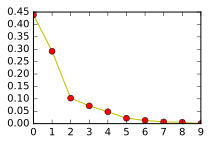


Using 50 samples for training:
1th eigenvector: 
[-0.36074472  0.04586331 -0.14700784  0.21151058 -0.23564709 -0.3775952
 -0.38762705  0.23752171 -0.2339237  -0.38124082 -0.00746195 -0.22962842
 -0.37918735]
10th eigenvector: 
[-0.32656667  0.11534686  0.57177716 -0.5509419  -0.15439106  0.09300774
  0.06585905 -0.31385883 -0.12714822 -0.2333455   0.0708041  -0.19313485
 -0.036336  ]


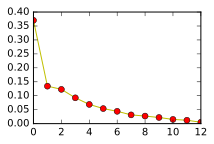

In [120]:
# Analyze the wine-database first
pcaResult, trainingData = [], []

classLabels = [1,2]
classColumnName = wineHeaders[0]
loadedData = loadWineDatabase()

for iteration in range(0,2):
    plt.figure(figsize=(3,2))
    trainingData.append(getTrainingData(iteration, loadedData, classColumnName, classLabels))
    print("\nUsing %s for training:" %(identificationStrings[iteration]))
    performPCA(trainingData[iteration]['data'].as_matrix(), pcaResult) 
    visualizeEigenvectors(pcaResult[iteration], [0,9])

I also use a variable number of eigenvectors for the reconstruction, discarding those for which the ratio: (eigenvalue)/(sum of eigenvalues) falls below a threshhold (I use a threshhold of 0.03). Using this to reconstruct a test-example, I get the following reconstruction errors (I report both the standardized and non-standardized errors):

In [121]:
#Wine data continue visualization
threshHold = 0.03

for iteration in range(0,len(pcaResult)):   
    print("When using %s for training:" %(identificationStrings[iteration]))
    testingData = getWineTestingData(loadedData, trainingData[iteration]['data'])
    testingSample = testingData['data'].sample()
    
    standardizedSample = standardize(testingSample, pcaResult[iteration].mean, pcaResult[iteration].deviation)

    reconstructionStandardized = computeLossyReconstruction(standardizedSample, pcaResult[iteration], threshHold)
    reconstructionUnstandardized = computeLossyReconstruction(testingSample, pcaResult[iteration], threshHold)
    print("Reconstruction error (standardized):", np.linalg.norm(reconstructionStandardized - standardizedSample))
    print("Reconstruction error:", np.linalg.norm(reconstructionUnstandardized - testingSample), "\n")

When using 5 samples for training:
Number of eigenvectors being used  6
Number of eigenvectors being used  6
Reconstruction error (standardized): 2.71043010221
Reconstruction error: 382.636408354 

When using 50 samples for training:
Number of eigenvectors being used  9
Number of eigenvectors being used  9
Reconstruction error (standardized): 1.52713874005
Reconstruction error: 271.290247093 



For mnist, I show the 10th eigenvector when using just 5 samples from each class and the 20th otherwise. The most important eigenvector, the 10th eigenvector and the plot for the ratio of the sorted eigenvalues to the sum of the eigenvalues for the wine dataset for two runs, one with 5 and the other time with 50 random samples of each class selected for training are:

In [122]:
#Analyze mnist
## Change this to location of data-bases
mnistTrainDataPath = "data/train.csv"
mnistTestDataPath = "data/test.csv"

mnistTrainData = pandas.read_csv(mnistTrainDataPath, header=None)
mnistTrainData = mnistTrainData.transpose()
mnistTestData = pandas.read_csv(mnistTestDataPath, header=None)
mnistTestData = mnistTestData.transpose()


Using 5 samples for training:


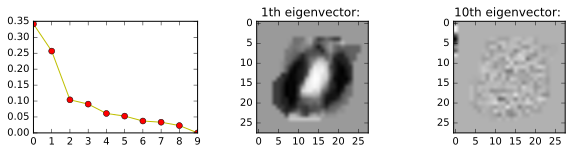


Using 50 samples for training:


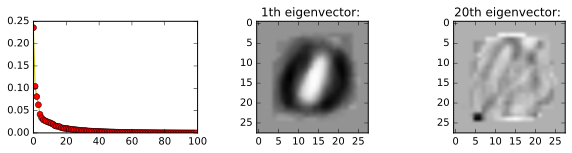

In [131]:
classLabels=[0,1]
classColumnName = 784
trainData = mnistTrainData[mnistTrainData[classColumnName].isin(classLabels)]
testData =  mnistTestData[mnistTestData[classColumnName].isin(classLabels)]
pcaResult, trainingData = [], []

for iteration in range(0,2):
    plt.figure(figsize=(10,2))
    trainingData.append(getTrainingData(iteration, trainData, classColumnName, classLabels))

    print("\nUsing %s for training:" %(identificationStrings[iteration]))
    performPCA(trainingData[iteration]['data'].as_matrix(), pcaResult)
    visualizeEigenImages(pcaResult[iteration], [0,9 if iteration == 0 else 19])

Similar to the wine data-set, I again use a variable number of eigenvectors for the reconstruction, discarding those for which the ratio: (eigenvalue)/(sum of eigenvalues) falls below a threshhold (I use a threshhold of 0.0005 here). Using this to reconstruct a test-example, I get the following reconstruction and errors:

When using 5 samples for training:
Number of eigenvectors being used  10
Quantitative reconstruction error: 6.19755694843


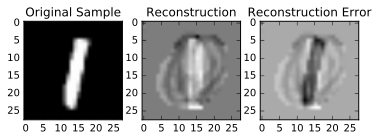

When using 50 samples for training:
Number of eigenvectors being used  76
Quantitative reconstruction error: 2.40242376975


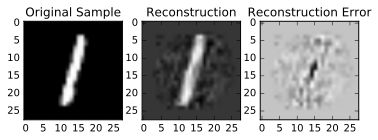

In [124]:
#Mnist data continue visualization
threshHold = 0.0005

for iteration in range(0,len(pcaResult)): 
    testingData = {'labels': testData[classColumnName], 'data' : testData.drop(classColumnName, axis=1)}
    testingSample = testingData['data'].sample().as_matrix()

    print("When using %s for training:" %(identificationStrings[iteration]))
    reconstructionNonStandardized = computeLossyReconstruction(testingSample, pcaResult[iteration], threshHold)

    visualizeEigenImage(testingSample.transpose(), 0, (1,3,1), "Original Sample")
    visualizeEigenImage(reconstructionNonStandardized.transpose(), 0, (1,3,2), "Reconstruction")
    visualizeEigenImage((reconstructionNonStandardized - testingSample).transpose(), 0, (1,3,3), "Reconstruction Error")
    print("Quantitative reconstruction error:", np.linalg.norm(reconstructionNonStandardized - testingSample))
    plt.show()

##LDA

I perform LDA for class discrimination maximizing dimensionality reduction after performing PCA for class agnostic dimensionality reduction. The most important eigenvector, the 10th eigenvector and the plot for the ratio of the sorted eigenvalues to the sum of the eigenvalues for the wine dataset for two runs, one with 5 and the other time with 50 random samples of each class selected for training are:

In [125]:
#LDA
#Calculate sorted eigenValues and eigenVectors for passed in data. Data is assumed to consist of one data-point in each row
def LDA(data, labels):
    uniqueLabels = np.unique(labels)
    classDatas, classMeans = [], []
    for classLabel in uniqueLabels:
        classDatas.append(data[labels == classLabel])
    classMeans = [classData.mean(axis=0) for classData in classDatas]
    scaledDatas = classDatas
    betweenClassScatter = np.outer(classMeans[0] - classMeans[1],classMeans[0] - classMeans[1])
    withinClassScatter = sum(np.cov(scaledData, rowvar=0) for scaledData in scaledDatas)
    desiredMatrix = np.linalg.inv(withinClassScatter).dot(betweenClassScatter)
    eigenValues, eigenVectors = np.linalg.eigh(desiredMatrix)
    eigenValues = eigenValues[::-1] #Eigh returns these in ascending order
    eigenVectors = eigenVectors[::-1]

    if TEST_MODE:
         #Check things are what they seem using self written functions
         withinClassScatter = sum(np.cov(scaledData, rowvar=0) for scaledData in scaledDatas)
         withinClassScatterSelf = sum(scaledData.transpose().dot(scaledData)/(
                                       scaledData.shape[0]-1) for scaledData in scaledDatas)
         #assert(np.allclose(withinClassScatter, withinClassScatterSelf))
         assert(np.allclose(eigenVectors[:,1].dot(eigenVectors[:,0].T), 0)) #See that columns are orthogonal       
    return eigenValues, eigenVectors, classMeans, withinClassScatter/2

def performLDA(data, labels):
    eValues, eVectors, means, covariance = LDA(data, labels)
    return LDAResult(eValues, eVectors, means, covariance)


Using 5 samples for training:
First reducing dimensions by PCA to 6
1th eigenvector: 
[ 0.29843372  0.66332795 -0.25177639 -0.06559815 -0.27536181 -0.16917021
  0.08292033  0.28106747 -0.16475257  0.20097222  0.10967338  0.36485704
 -0.01547049]
6th eigenvector: 
[ 0.04976015  0.18888549  0.30857903  0.35719219  0.53742549 -0.3754083
 -0.22672149  0.4567791  -0.06042899  0.01389432 -0.10547593 -0.17664826
  0.05529106]


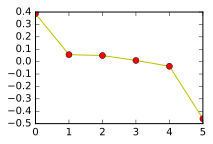


Using 50 samples for training:
First reducing dimensions by PCA to 8
1th eigenvector: 
[-0.31813651  0.28219942 -0.10883571  0.06746691 -0.08983933  0.13389594
  0.01737428  0.24901605 -0.12166199 -0.45685287  0.32797142  0.36946639
 -0.49684877]
8th eigenvector: 
[-0.28705488  0.20787809 -0.01802137  0.43791094 -0.12295442 -0.25010104
 -0.08499514 -0.14146212  0.66773616 -0.10349893 -0.27291773 -0.17162908
 -0.12987367]


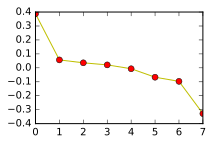

In [126]:
# Analyze the wine-database first
classLabels = [1,2]
classColumnName = wineHeaders[0]
loadedData = loadWineDatabase()

ldaResult, pcaResult, trainingData = [], [], []
threshHold = 0.05
for iteration in range(0,2):
    plt.figure(figsize=(3,2))
    trainingData.append(getTrainingData(iteration, loadedData, classColumnName, classLabels))
    
    print("\nUsing %s for training:" %(identificationStrings[iteration]))    
    performPCA(trainingData[iteration]['data'].as_matrix(), pcaResult)
    numBasis = getNumEigenVectorsToUse(pcaResult[iteration], threshHold)
    print("First reducing dimensions by PCA to %d" %(numBasis))
    trainingReducedDim = getProjection(trainingData[iteration]['data'].as_matrix(), pcaResult[iteration], numBasis)
    ldaRes = performLDA(trainingReducedDim, trainingData[iteration]['labels'].as_matrix())
    ldaResUpdatedEigenVectors = (getReconstruction(ldaRes.eigenVectors.T, pcaResult[iteration], numBasis)).T
    ldaResult.append(LDAResult(ldaRes.eigenValues, ldaResUpdatedEigenVectors, ldaRes.means, ldaRes.covariance))
    visualizeEigenvectors(ldaResult[iteration], [0,min(numBasis-1, 20)])

I carry out LDA post PCA similarly for mnist data.


Using 5 samples for training:
First reducing dimensions by PCA to 7


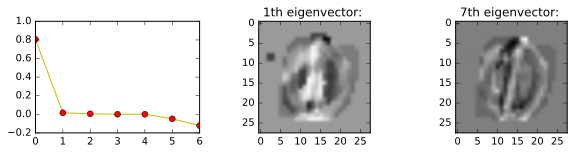


Using 50 samples for training:
First reducing dimensions by PCA to 6


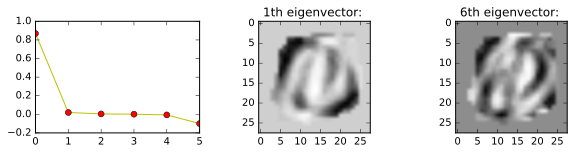

In [127]:
#Analyse mnist
classLabels=[0,1]
classColumnName = 784
trainData = mnistTrainData[mnistTrainData[classColumnName].isin(classLabels)]
testData =  mnistTestData[mnistTestData[classColumnName].isin(classLabels)]
pcaResult, ldaResult, trainingData = [], [], []

for iteration in range(0,2):
    plt.figure(figsize=(10,2))
    trainingData.append(getTrainingData(iteration, trainData, classColumnName, classLabels))
    
    print("\nUsing %s for training:" %(identificationStrings[iteration]))    
    performPCA(trainingData[iteration]['data'].as_matrix(), pcaResult)
    numBasis = getNumEigenVectorsToUse(pcaResult[iteration], threshHold)
    print("First reducing dimensions by PCA to %d" %(numBasis))
    trainingReducedDim = getProjection(trainingData[iteration]['data'].as_matrix(), pcaResult[iteration], numBasis)
    ldaRes = performLDA(trainingReducedDim, trainingData[iteration]['labels'].as_matrix())
    ldaResUpdatedEigenVectors = (getReconstruction(ldaRes.eigenVectors.T, pcaResult[iteration], numBasis)).T
    ldaResult.append(LDAResult(ldaRes.eigenValues, ldaResUpdatedEigenVectors, ldaRes.means, ldaRes.covariance))
    visualizeEigenImages(ldaResult[iteration], [0,min(len(ldaResult[iteration].eigenValues)-1, 19)])


Lets view the reconstructions from this:

When using 5 samples for training:
Number of eigenvectors being used  6
Quantitative reconstruction error: 7.86467257675


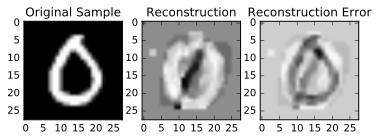

When using 50 samples for training:
Number of eigenvectors being used  5
Quantitative reconstruction error: 8.86273990486


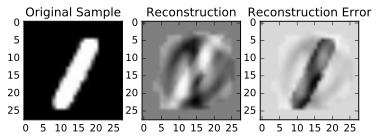

In [128]:
#Mnist data continue visualization
threshHold = 0.0005

for iteration in range(0,len(pcaResult)): 
    testingData = {'labels': testData[classColumnName], 'data' : testData.drop(classColumnName, axis=1)}
    testingSample = testingData['data'].sample().as_matrix()

    print("When using %s for training:" %(identificationStrings[iteration]))
    reconstructionNonStandardized = computeLossyReconstruction(testingSample, ldaResult[iteration], threshHold)

    visualizeEigenImage(testingSample.transpose(), 0, (1,3,1), "Original Sample")
    visualizeEigenImage(reconstructionNonStandardized.transpose(), 0, (1,3,2), "Reconstruction")
    visualizeEigenImage((reconstructionNonStandardized - testingSample).transpose(), 0, (1,3,3), "Reconstruction Error")
    print("Quantitative reconstruction error:", np.linalg.norm(reconstructionNonStandardized - testingSample))
    plt.show()

Now, I use the discriminant to classify:

When using 5 samples for training:
Accuracy = 9.598109%


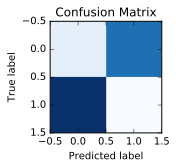

When using 50 samples for training:
Accuracy = 46.335697%


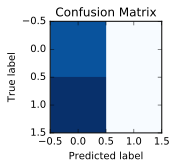

In [129]:
from sklearn.metrics import confusion_matrix
threshHold = 0.0005

for iteration in range(0,len(ldaResult)): 
    print("When using %s for training:" %(identificationStrings[iteration]))
    plt.figure(figsize=(2,2))
    testingData = {'labels': testData[classColumnName], 'data' : testData.drop(classColumnName, axis=1)}
    numBasis = getNumEigenVectorsToUse(pcaResult[iteration], threshHold)
    testingReducedDim = getProjection(testingData['data'].as_matrix(), ldaResult[iteration], numBasis)
    covarianceInv = np.linalg.inv(ldaResult[iteration].covariance)
    w = covarianceInv.dot(ldaResult[iteration].means[1] - ldaResult[iteration].means[0])
    c = 0.5 * (0.5 - ldaResult[iteration].means[1].dot(covarianceInv).dot(ldaResult[iteration].means[1].transpose())
                   + ldaResult[iteration].means[0].dot(covarianceInv).dot(ldaResult[iteration].means[0].transpose()))
    wtx = w.dot(testingReducedDim.transpose())
    classes = np.zeros(wtx.shape)
    classes[wtx > c] = 1
    displayAccuracy(classes, testingData['labels'])
    plotConfusionMatrix(classes, testingData['labels'])
    plt.show()

In [130]:
#Train
trainingMeans = [trainingDataUnlabeled[0].mean(), trainingDataUnlabeled[1].mean()]
trainingVariance = totalTrainingData.var()
weights = (trainingMeans[1]*trainingMeans[1] - trainingMeans[0]*trainingMeans[0])/trainingVariance
bias = 0.5 + ((trainingMeans[1]*trainingMeans[1] - trainingMeans[0]*trainingMeans[0])/2*trainingVariance).sum()

    #Test
    #for i in testingData[1].index[0:1]:
    #    data = testingData[1].ix[i]
    #    print(weights, data)
    #    label = 0 if weights.dot(data) > 0 else 1

array1 = np.array([[1,2,3],[0, 1, 2]])
array2 = np.array([0, 1, 1])
result = array1/array2
result[:,array2 == 0] = 0
print(result)

NameError: name 'trainingDataUnlabeled' is not defined